## Goal

The goal of this project is to predict an NFL receiver's separation at the time of pass arrival. I will be using the NFL's player-tracking data set from the last 3 seasons (2017-2019) to create these predictions

## Motivation

All receivers are NOT built equal. Receivers like Tyler Lockett (Seahawks) are short, quick, and line up in the 'Slot' often, while others like Allen Robinson (Bears) are tall, strong, and often line up out 'Wide'. Since these players have different body types, abilities, and team roles, I don't think they would have similar average receiver separations. To this end, I want to look into how much separation a receiver gains RELATIVE to their situations. 

For example, a receiver that lines up out 'Wide', is pressed at the line of scrimage, and is targeted 20 yards downfield should have little to no separation when the pass arrives. In contrast, a reciver that lines up in the backfield and is targeted 3 yards behind the line of scrimmage should expect to have more separation.

When aggregated over a course of a game, season, or career, this 'expected separation' value should bring context into the players TRUE ability to separate given their in-play circumstances.



In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
import fancyimpute 

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
LoadData = "../data/ExpSepPos.csv"

df = pd.read_csv(LoadData, index_col = False)

random_state = 1

In [3]:
print(df.shape)
print(max(df['GameId']))
print(min(df['GameId']))
df.head()

(53710, 31)
2020020200
2017090700


,GameId,PlayId,Season,Team,Receiver,Nearest_Defender,Nearest_Def_Position,Opp,Wk,Qtr,...,Air_Dist,Air_Time,TTT,Separation,QB_Separation,QBP,QB_Scramble_Yds,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,2017102910,2814,2017,PIT,JuJu Smith-Schuster,Quandre Diggs,SS,DET,8,3,...,33.119846,1.539,2.756,1.785385,2.084347,0,4.12,26.303329,1.145455,37.540001
1,2018112509,2475,2018,PIT,JuJu Smith-Schuster,Bradley Roby,CB,DEN,12,3,...,37.510450,2.202,2.436,2.674790,1.540033,1,7.09,12.303331,3.763636,40.230003
2,2017111208,2731,2017,LA,Robert Woods,Johnathan Joseph,CB,HOU,10,3,...,52.871040,2.633,3.135,3.966674,3.386576,0,7.52,17.230000,1.247727,58.880001
3,2019120800,2777,2019,ATL,Olamide Zaccheaus,Donte Jackson,CB,CAR,14,3,...,49.233444,3.018,2.771,0.910220,2.814427,0,5.20,19.433328,1.329546,56.439999
4,2019101310,1630,2019,NYJ,Robby Anderson,Jeff Heath,SS,DAL,6,2,...,46.187710,2.636,3.003,1.676305,1.471224,1,6.58,15.103330,3.477273,57.060001


Our Dataset spans 3 years (2017-2020) and includes regular and postseason games. We have a total of 53,710 total passes with non-null receiver separations to work with. 

# Predicting Receiver Separation

## Data Cleaning

- Handle missing values
    - Discuss various ways to impute missing/null values
    - Remove Rows with missing cushion?
- Handle Outliers

## Data Exploration

- Feature Analysis
    - Numerical Features
        - Discrete Features
        - Continuous Features
    - Categorical Features
- Feature Engineering
    - Nearest Defender Position into broader groups
    
## Model Selection

- Choosing the right Model
    - Linear Regression
        - LASSO Regression
        - Ridge Regression
    - Random Fore

In [4]:
# Describing all the Numerical Features
df.describe()
COLS = df.columns.to_list()

In [5]:
# Describing all the Categorical Features
#df.describe(include=['O'])

## Dropping non-relevant features 

Right off the bat, I think a lot the variables in this dataset will not be useful in predicting reciever separation. Also, there are a lot features in this set that describe the outcome of the event. These features (Pass Yards, TD, INT) cannot be used in prediction. For features that I am skeptical of, but not sure about their effect, I will leave alone, otherwise I will drop all non-essential features below.

In [6]:
IrrelevantCols = ['GameId', 'PlayId', 'Season', 'Wk', 'Cmp', 'Team', 'Receiver', 'Nearest_Defender', 'Opp', 'Wk', 'Cmp', 'Pass Yds','TD', 'INT',
 'Comp_Prob', 'Separation', 'Time', 'QB_Scramble_Yds']

# Drop all irrelevant columns and output variable (separation)
Features = df.drop(IrrelevantCols, axis = 1)

#Create 1-dimensional array of output variable (separation)
Output = df['Separation']

#Output top 5 rows of Features Dataframe
cols = len(Features.columns)
print('We are left with ' + str(cols) + ' features to help with prediction')
Features.head()


We are left with 15 features to help with prediction


,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,SS,3,3,9,Slot,3.66,24.54,33.119846,1.539,2.756,2.084347,0,26.303329,1.145455,37.540001
1,CB,3,1,10,Wide,2.66,27.23,37.510450,2.202,2.436,1.540033,1,12.303331,3.763636,40.230003
2,CB,3,2,8,Wide,10.23,42.88,52.871040,2.633,3.135,3.386576,0,17.230000,1.247727,58.880001
3,CB,3,3,8,Wide,6.74,39.44,49.233444,3.018,2.771,2.814427,0,19.433328,1.329546,56.439999
4,SS,2,1,10,Wide,3.23,39.06,46.187710,2.636,3.003,1.471224,1,15.103330,3.477273,57.060001


## Target Variable (Separation)

Let's take a look at our target variable, Reciever Separation



The Kurtosis of the distribution of the target variable is 1.7
The Skew of the distribution of the target variable is 1.2


count    53710.000000
mean         3.244240
std          2.435761
min          0.020000
25%          1.292652
50%          2.613341
75%          4.589033
max         19.226980
Name: Separation, dtype: float64

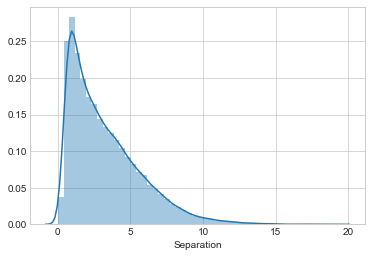

In [7]:
# How Normally Distributed is our Output Variable (Separation)

plt.style.use('seaborn-whitegrid')
Fig = sns.distplot(df['Separation'])

K = round(stats.kurtosis(df['Separation']),1)
S = round(stats.skew(df['Separation']), 1)
p_value = stats.shapiro(df['Separation'])[1]
    
print('\n')
print('The Kurtosis of the distribution of the target variable is ' + str(K))
print('The Skew of the distribution of the target variable is ' + str(S))

df['Separation'].describe()


As we can see, our data is very skewed to the right, or positively skewed, making the distribution of Separation noticably non-normal (non-gaussian). 

Based on my understanding of the game of football, the only time we would expect receiver separations to be greater than 10 yards, are in instances where the targeted player is not a current threat to gain yards (passes targeting receivers behind the line of scrimmage) OR mistakes in coverage.

We know that linear regression works more effectively when the distribution of output variable normally distributed, so I applied a **Cube Root Transform** to the output variable to see if that helps with the skew and kertosis.

In [8]:
def get_cube_root(num):
    return num ** (1. / 3)



The Kurtosis of the distribution of the target variable is -0.7
The Skew of the distribution of the target variable is 0.2


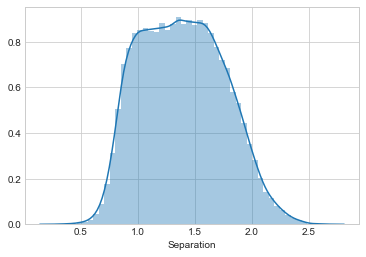

In [9]:
plt.style.use('seaborn-whitegrid')

#Apply Log Transform here
CubeRootSep = get_cube_root(df['Separation'])

Fig = sns.distplot(CubeRootSep)

K = round(stats.kurtosis(CubeRootSep),1)
S = round(stats.skew(CubeRootSep), 1)
p_value = stats.shapiro(CubeRootSep)[1]
    
print('\n')
print('The Kurtosis of the distribution of the target variable is ' + str(K))
print('The Skew of the distribution of the target variable is ' + str(S))



## Missing Values

In [10]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(Features)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,14125,26.3
Receiver_Location,108,0.2


Of the 14125 missing cushion values, how many were from targets from receivers who lined up in the backfield?

In [11]:
Cush = df[df['Cushion'].isna()]
Cush['Receiver_Location'].value_counts()

Backfield    9846
Slot         2742
Tight        1334
Wide          114
Name: Receiver_Location, dtype: int64

In [12]:
Backfield = df[(df['Receiver_Location'] == 'Backfield')][['Cushion', 'Separation']]
print('There were ' + str(len(Backfield)) + ' plays where the player who lined up in the backfield was targeted')
print('The average Cushion of a player who lines up in the Backfield is ' + str(Backfield['Cushion'].mean()))
print('The average Separation of a player who lines up in the Backfield is ' + str(round(Backfield['Separation'].mean(), 2)))


There were 9846 plays where the player who lined up in the backfield was targeted
The average Cushion of a player who lines up in the Backfield is nan
The average Separation of a player who lines up in the Backfield is 4.77


Every target to a player that lined up in the *'Backfield'* in this dataset has a **null cushion value**. This makes sense, as they are far from the line of scrimmage, often behind, or to the side of the QB at the time of snap, and roughly 5-10 yards behind the line of scrimmage when the ball is snapped, making it nearly impossible to determine who is covering them, if anyone specific at all. 

If all of the Backfield targets are missing a cushion value, this means that this type of data is *Missing Not at Random* ([relevant wiki](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random)). With data that is missing Not at Random, it is not 'ignorable' since removing all of these rows would drastically change the distribution of Separation values. 

That being said, the goal of this project is try to predict a players separation as accurately as possible, and if we remove just the backfield targets, we don't necessarily lose any insight in how to predict Separation for non-backfield targets. 

## Ways to deal with missing Cushion values 
 1. Impute the missing values
     - Replace missing values with a summary statistic (like a mean/median)
         - This would introduce a lot bias into the distribution of Cushion in the whole data set (25% would be one number)
     - Use something like kNN (K-nearest neighbors) or other ML model to predict Cushion 
         - 'Backfield' rows have 0 cushion values
         - We have to use other Features in the dataset to draw from
 2. Remove all rows where the receiver location is 'Backfield' 
     - This will remove ~10,000 rows, losing data is never ideal, but sometimes necessary 
     - Predicting non-backfield targets will likely be more accurate after removing these rows
     - Remember our goal: creating a way to compare receivers
         - Since RBs are the primary receiver out of the backfield, I am not as concerned about their ability to create separation

Let's take a look at the distribution of Separations grouped by Receiver Location to see if they are differences:

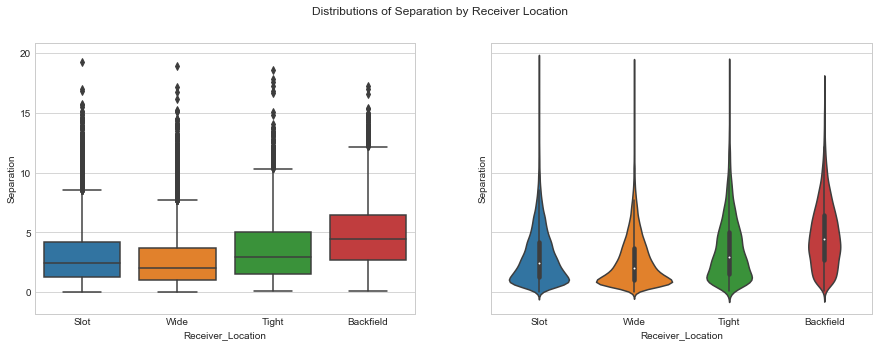

In [13]:
#Look at the distributions of Separation by Pre-Snap Receiver Location

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

fig.suptitle('Distributions of Separation by Receiver Location')
sns.boxplot(x="Receiver_Location", y="Separation", data=df, ax = ax1)
sns.violinplot(x="Receiver_Location", y="Separation", data=df, ax = ax2)

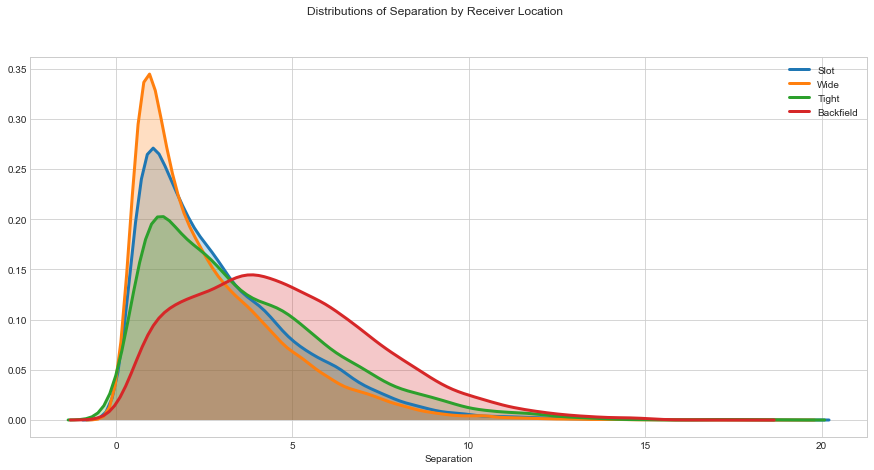

In [14]:
# List of four recevier locations to plot
RecLocations = list(df['Receiver_Location'].unique())

fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Separation by Receiver Location')

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    subset = df[df['Receiver_Location'] == loc]
    
    # Draw the density plots
    sns.distplot(subset['Separation'], ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = loc)
    


In [15]:
print('The mean separation of Backfield targets is ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Separation'].std(), 1))+ ' yards')
print('The mean separation of NON-Backfield targets is ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].mean(), 1)) + ' yards, +/- ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Separation'].std(), 1))+ ' yards')

The mean separation of Backfield targets is 4.8 yards, +/- 2.7 yards
The mean separation of NON-Backfield targets is 2.9 yards, +/- 2.2 yards


### Backfield Targets

As we can see, Backfield targets have a **considerably higher** average separation and a distinctly different distribution from non-Backfield targets.

This makes sense, as receivers targeted in the backfield do not have pre-snap cushions, meaning that no one is lined up close to them at the time of snap. Since backfield targets have no one near them at the time of snap, receivers targeted in the backfield are often wide open at the time the pass arrives. This is because the defense either hasn't had enough time to get to the backfield to gaurd the player, or the player does not pose as big of a threat to the defense as the rest of the receivers, so the defense does not guard them as closely. 

Let's check this to see if our assumptions are correct - 

*Are targets to receivers in the backfield shorter (less air yards) and therefore warrant more separation?*



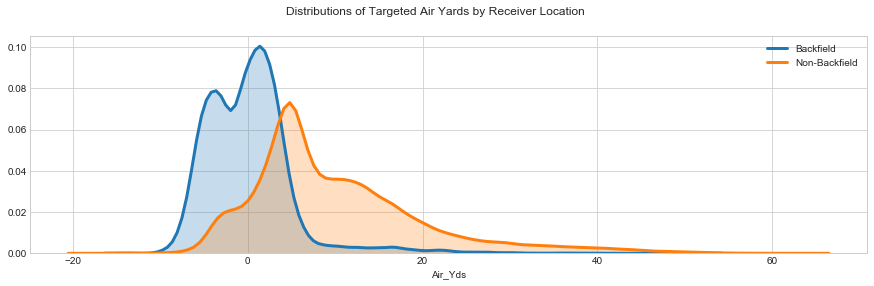

In [16]:
# List of four recevier locations to plot

RecLocations = ['Backfield', 'Non-Backfield']

Bkfd = df[df['Receiver_Location'] == 'Backfield']
NonBkfd = df[df['Receiver_Location'] != 'Backfield']


fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Distributions of Targeted Air Yards by Receiver Location')

# Iterate through the four receiver locations
for loc in RecLocations:
    # Subset to the Receiver location
    if loc == 'Backfield':
        subset = Bkfd
    else:
        subset = NonBkfd
    
    # Draw the density plots
    
    g = sns.distplot(subset['Air_Yds'], ax = ax, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = loc)

In [17]:
print('The average target to a receiver lined up in the Backfield is ' + str(round(df[df['Receiver_Location'] == 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')
print('The average target to a receiver NOT lined up in the Backfield is ' + str(round(df[df['Receiver_Location'] != 'Backfield']['Air_Yds'].mean(), 2)) + ' yards downfield')

The average target to a receiver lined up in the Backfield is 0.04 yards downfield
The average target to a receiver NOT lined up in the Backfield is 10.06 yards downfield


### Dropping all rows for Targets in the Backfield

As we thought, backfield targets are markedly different from non-backfield targets, and exist almost exclusively 5 yards behind (or beyond) the line of scrimmage, while non-backfield targets occur downfield far more frequently. 


Since **all** of the cushion values are missing for targets to recievers who line up in the backfield, and they they usually are not indicative of anything the receiver is inherently doing to create separation, I am choosing to drop all rows targeting receivers who line up in the 'Backfield'

In [18]:
NB_Features = Features[Features['Receiver_Location'] != 'Backfield']
print(len(NB_Features))
missing_values_table(NB_Features)

43864
Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4279,9.8
Receiver_Location,108,0.2


## Drop all Missing Receiver Location Rows

Since the Missing Receiver_Locations represent ~0.2% of our data set, we can comfortably drop those offending rows.

In [19]:
NB_Features = NB_Features[NB_Features['Receiver_Location'].notnull()]
print(len(NB_Features))
missing_values_table(NB_Features)

43756
Your selected dataframe has 15 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Cushion,4190,9.6


We are left with 4190 misssing cushion values. 

These missing values, unlike the missing cushion values for 'Backfield' Targets, are *'missing at random'*. There is nothing in the dataset that would indicate that these cushions can be inferred from another feature, so I want to look into a way to impute these values effectively and efficiently. 

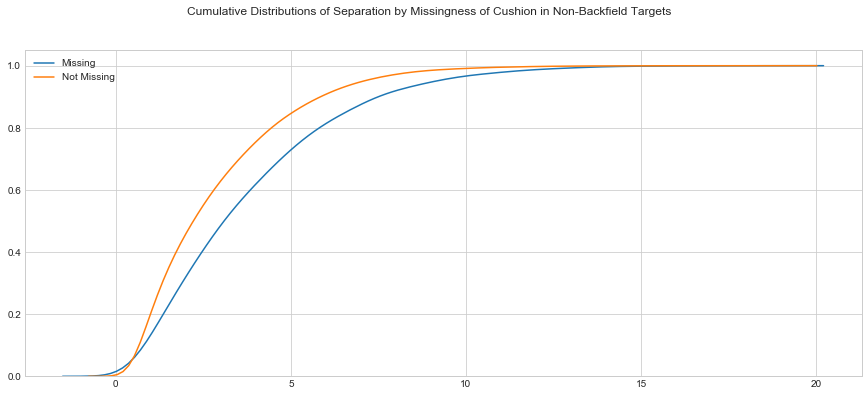

In [20]:
# List of two types of data to plot

DataTypes = ['Missing', 'Not Missing']

df_1 = df[df['Receiver_Location'] != 'Backfield']


M = df_1[df_1['Cushion'].isna()]
NM = df_1[df_1['Cushion'].notnull()]


fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
fig.suptitle('Cumulative Distributions of Separation by Missingness of Cushion in Non-Backfield Targets')

# Iterate through the four receiver locations
for loc in DataTypes:
    # Subset to the DataType
    if loc == 'Missing':
        subset = M
    else:
        subset = NM
    
    # Draw the density plots
    
    g = sns.kdeplot(subset['Separation'], ax = ax,
                     cumulative = True,
                 label = loc)

In [21]:
print('Targets with missing Cushion had an average Separation of ' + str(round(M['Separation'].mean(), 2)) + ' yards')
print('Targets with Cushion had an average Separation of ' + str(round(NM['Separation'].mean(), 2)) + ' yards')

Targets with missing Cushion had an average Separation of 3.72 yards
Targets with Cushion had an average Separation of 2.81 yards


## Test to see if Distributions are statistically different from each other

If we find that these two samples sets (rows with/without missing Cushion values) are statistically different, I must come up with a way to impute them that maintains their differences. If they are statistically the same, I can safely remove all offending rows.

In order to confirm that these two distributions are statistically different, I run a 2-sample Kolmogorov-Smirnov test [link](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

In [22]:
from scipy.stats import ks_2samp

p_value = ks_2samp(M['Separation'], NM['Separation'])[1]

print('Our p-value for tke K-S test is ' + str(p_value))
print('Since our p-value is less than 0.05, we must find a way to deal with these values, we cannot remove them')

Our p-value for tke K-S test is 4.951603139160891e-73
Since our p-value is less than 0.05, we must find a way to deal with these values, we cannot remove them


### Methods of Imputation

1. Replace all missing Cushion values with a summary statistic (mean/median) of Cushion
    - **Pros**: Simple, understandable, and fast
    - **Cons**: Since we are replacing ~10% of our data, this will severely bias our distribution and negatively affect our train/validation accuracies
2. Single Imputation from Regression (kNN, Neural Networks)
    - **Pros**: Introduces less bias than mean/median imputation, is still relatively simple
    - **Cons**: Slower, still does not generate entries that accurately reflect the distribution of the underlying data
3. Multiple Imputation from Chained Equations (MICE)
    - **Pros**: Most accurate, creates multiple imputations and analyzes pool of possible choice to create imputation
    - **Cons**: Slowest and less simple than sinlge imputation
    
    
Due to the fact that I am looking to create the most accurate prediction of Separation possible, and am not too concerned with the comprehensability of how the imputed values were calculated, so long as they pass a few sanity checks. So I am choosing **MICE**. 

In [23]:
# Transform Categorical Features to One-Hot Encoded Binary Variables

NB_Features_encoded = pd.get_dummies(NB_Features)

NB_Features_encoded.head()


,Qtr,Down,To Go,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,...,Nearest_Def_Position_NT,Nearest_Def_Position_OLB,Nearest_Def_Position_S,Nearest_Def_Position_SAF,Nearest_Def_Position_SS,Nearest_Def_Position_TE,Nearest_Def_Position_WR,Receiver_Location_Slot,Receiver_Location_Tight,Receiver_Location_Wide
0,3,3,9,3.66,24.54,33.119846,1.539,2.756,2.084347,0,...,0,0,0,0,1,0,0,1,0,0
1,3,1,10,2.66,27.23,37.510450,2.202,2.436,1.540033,1,...,0,0,0,0,0,0,0,0,0,1
2,3,2,8,10.23,42.88,52.871040,2.633,3.135,3.386576,0,...,0,0,0,0,0,0,0,0,0,1
3,3,3,8,6.74,39.44,49.233444,3.018,2.771,2.814427,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,10,3.23,39.06,46.187710,2.636,3.003,1.471224,1,...,0,0,0,0,1,0,0,0,0,1


In [30]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

MICE_imputer = IterativeImputer(initial_strategy="median", max_iter = 1000, random_state = random_state)

NB_Features_enc_imp = MICE_imputer.fit_transform(NB_Features_encoded)

Cush_Fill = NB_Features_enc_imp[:,3]
NB_Features['Cushion'] = Cush_Fill

#Check how many null values there are
sum(NB_Features['Cushion'].isna())


0

## Handling Outliers

# Exploratory Data Analysis


In [29]:
NB_Features.dd

,Nearest_Def_Position,Qtr,Down,To Go,Receiver_Location,Cushion,Air_Yds,Air_Dist,Air_Time,TTT,QB_Separation,QBP,Receiver_Dist_From_Sideline,QB_Speed_at_Pass,EZ_Dist
0,SS,3,3,9,Slot,3.660000,24.54,33.119846,1.539,2.756,2.084347,0,26.303329,1.145455,37.540001
1,CB,3,1,10,Wide,2.660000,27.23,37.510450,2.202,2.436,1.540033,1,12.303331,3.763636,40.230003
2,CB,3,2,8,Wide,10.230000,42.88,52.871040,2.633,3.135,3.386576,0,17.230000,1.247727,58.880001
3,CB,3,3,8,Wide,6.740000,39.44,49.233444,3.018,2.771,2.814427,0,19.433328,1.329546,56.439999
4,SS,2,1,10,Wide,3.230000,39.06,46.187710,2.636,3.003,1.471224,1,15.103330,3.477273,57.060001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53703,SS,3,1,4,Wide,4.720000,-10.21,7.060149,3.713,0.747,3.395777,0,24.313330,2.209091,24.209999
53704,DT,3,1,10,Wide,7.610000,-5.23,0.940319,0.167,0.968,4.633282,0,23.673330,3.947727,59.770000
53705,CB,1,1,10,Wide,9.530000,-1.78,16.905342,0.667,1.220,4.577390,0,12.313330,1.615909,32.220001
53707,LB,3,2,13,Wide,8.330000,-8.10,16.791906,1.535,2.769,5.016981,0,14.310000,4.397728,49.900002


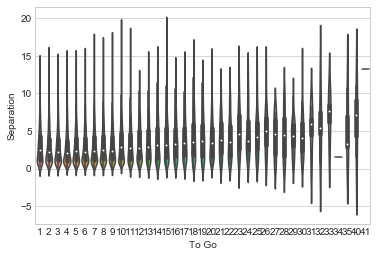

In [119]:
ax = sns.violinplot(x="To Go", y="Separation", data=df)

In [118]:
RecLoc_df = df[['Down', 'Separation']]
RecLoc_df.head()
RecLoc_df.groupby(['Down']).mean().round({'Separation': 2}).sort_values('Separation', ascending = False).reset_index()

,Down,Separation
0,1,3.43
1,2,3.30
2,3,2.96
3,4,2.52


### 